# Fully-developed turbulent flow in a channel

Joshua Brinkerhoff, UBC Okanagan, joshua.brinkerhoff@ubc.ca


In this exercise we will simulate fully-developed turbulent flow in a channel. The exercise is inspired by the RANS_Channel notebook by Otero and Pecnik https://github.com/Fluid-Dynamics-Of-Energy-Systems-Team/RANS_Channel.

To start, we will derive the simplified governing equations that apply to fully-developed turbulent channel flow. Consider the Reynolds-averaged Navier-Stokes equations for the mean velocity $\overline{u_i}$:

$$
\rho \left( \dfrac{\partial \overline{u}_i}{\partial t} + \overline{u}_j \dfrac{\partial \overline{u}_i}{\partial x_j} \right) = -\dfrac{\partial \overline{p}}{\partial x_i} + \dfrac{\partial}{\partial x_j} \left( \overline{\tau_{ij}} - \rho \overline{u^{\prime}_i u^{\prime}_j} \right).
$$

Notice that the viscous term on the RHS has two components: the mean viscous shear stress $\overline{\tau_{ij}}$ and the so-called _Reynolds shear stress,_ $\overline{u^{\prime}_i u^{\prime}_j }$. The mean strain is 

$$ \overline{\tau_{ij}} = \mu \left( \dfrac{\partial \overline{u_i}}{\partial x_j} + \dfrac{\partial \overline{u_j}}{\partial x_i} \right) $$

Under the _Bouissenesq approximation,_  we model the Reynolds stress as acting equivalently to the viscous stress using an effective eddy viscosity, $\mu_t$:

$$\rho \overline{u^{\prime}_i u^{\prime}_j} \approx \mu_t \left( \dfrac{\partial \overline{u_i}}{\partial x_j} + \dfrac{\partial \overline{u_j}}{\partial x_i} \right) $$

From this general form, let's rewrite the RANS equation for fully-developed turbulent flow in a channel. Our assumptions for fully-developed channel flow are:

\begin{align}
\dfrac{\partial}{\partial t} (\text{anything}) &= 0 \quad (\text{steady}) \\
\dfrac{\partial}{\partial x} (\text{anything}) &= 0 \quad (\text{fully-developed}) \\
\overline{v} &= 0 \quad (\text{Mean flow is parallel to the wall}) \\
\overline{u} &= f(y) 
\end{align}

With the above assumptions, the Reynolds stress reduces to

$$ \dfrac{d}{dy} \left( (\mu + \mu_t) \dfrac{\partial u}{\partial y} \right) = -1. $$

For simplicity, I have dropped the overbar, as mean velocity is implied, and I have replaced the pressure gradient with a constant body force value of $-1$. If we define an effective viscosity that accounts for both viscous and turbulence effects, $\mu_{eff} = \mu + \mu_t$, we can use the product rule to rewrite the above as:

$$ \left[ \dfrac{d \mu_{eff}}{d y} \dfrac{d}{dy} + \mu_{eff} \dfrac{d^2}{dy^2} \right] u = -1 $$

This is nicely expressed as a linear system $A u = -1$ which we can solve using a direct linear solver.

## Python code

The below sub-routine solves the RANS equations with a specified turbulence model.

In [18]:
def solveRANS(rho,mu,mesh,turbModel,ReTau):
    
    n    = mesh.nPoints
    u    = np.zeros(n)          # velocity 
    mut  = np.zeros(n)          # eddy viscosity 
       
    k    = 0.01*np.ones(n)      # turbulent kinetic energy
    e    = 0.001*np.ones(n)     # turbulent dissipation 
    v2   = 1/3*k                # wall normal turbulent fluctuations for V2F model
    om   = np.ones(n)           # specific turbulent dissipation for omega in SST
    nuSA = np.ones(n)/ReTau     # eddy viscisty for SA model
    
    residual   = 1.0e20
    iterations = 0
    
    print("Start iterating with", turbModel, "turbulence model")

    while residual > 1.0e-6 and iterations < 10000:

        # Solve turbulence model to calculate eddy viscosity 
        if   turbModel == "Cess":   mut        = Cess(rho,mu,ReTau,mesh)
        elif turbModel == "SA":     mut,nuSA   = SA(u,nuSA,rho,mu,mesh)
        elif turbModel == "MK":     mut,k,e    = MK(u,k,e,rho,mu,ReTau,mesh)
        elif turbModel == "SST":    mut,k,om   = SST(u,k,om,rho,mu,mesh)
        elif turbModel == "V2F":    mut,k,e,v2 = V2F(u,k,e,v2,rho,mu,mesh)
        else:                       mut        = np.zeros(n)

        # Solve momentum equation:  0 = d/dy[(mu+mut)dudy] - 1
        # diffusion matrix: mueff*d2phi/dy2 + dmueff/dy dphi/dy    
        A = np.einsum('i,ij->ij', mesh.ddy@(mu + mut), mesh.ddy) + np.einsum('i,ij->ij', mu + mut, mesh.d2dy2)

        # Solve 
        u_old = u.copy()
        u[1:n-1] = np.linalg.solve(A[1:n-1, 1:n-1], -np.ones(n-2))
        residual = np.linalg.norm(u-u_old)/n

        # Printing residuals
        if iterations%100 == 0: print("iteration: ",iterations, ", Residual(u) = ", residual)
        iterations = iterations + 1

    print("iteration: ",iterations, ", Residual(u) = ", residual)
    
    return u, mut, k, e, om

## Implemented turbulence models

### 1. Cess algebraic model

The simplest turbulence model we'll implement is the one by Cess, as detailed in #       Cess, R.D., "A survery of the literature on heat transfer in turbulent tube flow", Tech. Rep. 8-0529-R24, Westinghouse, 1958. Modified for channel flow by: Hussain, A.K.M.F. and Reynolds W.C., "Measurements in fully developed turbulent channel flow", ASME Journal of Fluid Eng., 1975.

$$   \dfrac{\mu_{eff}}{\mu} = \dfrac{1}{2} \left( 1 + \dfrac{1}{9} \kappa^2 Re_{\tau}^2 (2y-y^2)^2 (3 - 4y + 2y^2)^2 \left[ 1-\exp (-\frac{y^+}{A}) \right]^2 \right )^{1/2} - \dfrac{1}{2} $$

where 

$$ \kappa = 0.42$$
$$ A = 25.4 $$
$$ y^+ = y Re_{\tau} $$
$$ Re_{\tau} = \dfrac{\rho u^+ H}{\mu}$$
$$ H = \text{ channel height}$$
$$ u^+ = \sqrt{\frac{\tau_w}{\rho}}$$
$$ \tau_w = \mu \left(\frac{d u}{dy}\right)_w $$

In [10]:
def Cess(r,mu,ReTau,mesh):

    # distance to the wall
    d = np.minimum(mesh.y, mesh.y[-1]-mesh.y)

    # Model constants
    kappa   = 0.426
    A       = 25.4
    ReTauArr = np.ones(mesh.nPoints)*ReTau
    # distance to the wall in wall units
    yplus = d*ReTauArr
        
    df  = 1 - np.exp(-yplus/A)
    t1  = np.power(2*d-d*d, 2)
    t2  = np.power(3-4*d+2*d*d, 2)
    mut = 0.5*np.power(1 + 1/9*np.power(kappa*ReTauArr, 2)*(t1*t2)*df*df, 0.5) - 0.5
    
    return mut*mu

### 2. Spalart-Almaras model

The SA model consists of a transport equation for an eddy viscosity-like scalar derived using dimensional analysis, Galilean invariance and empiricism. Reference: Spalart, A. and Allmaras, S., "One equation turbulence model for aerodynamic flows", Recherche Aerospatiale-French edition, 1994.

$$ 0 = c_{b1} \hat{S} \tilde{\nu} - c_{w1} f_w \left(\frac{\tilde{\nu}}{y}\right)^2 + \dfrac{1}{c_{b3}} \dfrac{d}{dy}\left[ (\nu + \tilde{\nu}) \dfrac{d \tilde{\nu}}{dy}\right] + \dfrac{c_{b2}}{c_{b3}} \left(\dfrac{d \tilde{\nu}}{dy}\right)^2 $$ 

with the eddy viscosity $\mu_t = \rho \tilde{\nu} f_{\nu 1}$. Constants are:


$$ c_{v1} = 7.1 $$
$$ c_{b1} = 0.1355 $$
$$ c_{b2} = 0.622 $$
$$ c_{b3} = \dfrac{2}{3} $$
$$ c_{w1} = \dfrac{c_{b1}}{\kappa^2} + \dfrac{1.0+c_{b2}}{c_{b3}}$$
$$ c_{w2} = 0.3 $$
$$ c_{w3} = 2.0 $$
$$ \kappa = 0.41 $$
$$ f_{\nu 1} = \dfrac{\chi^3}{\chi^3 + c_{v1}^3} $$
$$ \chi = \dfrac{\tilde{\nu}}{\nu} $$


In [11]:
def SA(u,nuSA,r,mu,mesh):
    
    n = mesh.nPoints

    # Model constants
    cv1_3   = np.power(7.1, 3.0)
    cb1     = 0.1355
    cb2     = 0.622
    cb3     = 2.0/3.0
    inv_cb3 = 1.0/cb3
    kappa_2 = np.power(0.41, 2.0)
    cw1     = cb1/kappa_2 + (1.0+cb2)/cb3
    cw2     = 0.3
    cw3_6   = np.power(2.0, 6.0)
    
    # Model functions
    strMag        = np.absolute(mesh.ddy@u)   # VortRate = StrainRate in fully developed channel
    wallDist      = np.minimum(mesh.y, mesh.y[-1]-mesh.y) 
    wallDist      = np.maximum(wallDist, 1.0e-8)
    inv_wallDist2 = 1/np.power(wallDist, 2)

    chi           = nuSA*r/mu
    fv1           = np.power(chi, 3)/(np.power(chi, 3) + cv1_3)
    fv2           = 1.0 - (chi/(1.0+(chi*fv1)))
    inv_kappa2_d2 = inv_wallDist2*(1.0/kappa_2)
    Shat          = strMag + inv_kappa2_d2*fv2*nuSA
    inv_Shat      = 1.0/Shat
    r_SA          = np.minimum(nuSA*inv_kappa2_d2*inv_Shat, 10.0)
    g             = r_SA + cw2*(np.power(r_SA, 6) - r_SA)
    g_6           = np.power(g, 6)
    fw_           = np.power(((1.0 + cw3_6)/(g_6+ cw3_6)), (1/6))
    fw            = g*fw_

    # Eddy viscosity
    mut       = np.zeros(n)
    mut[1:-1] = fv1[1:-1]* nuSA[1:-1]*r
    mut[1:-1] = np.minimum(np.maximum(mut[1:-1], 0.0), 100.0)
    
    nueff = (mu/r + nuSA)
    fs    = np.ones(n)
    fd    = np.ones(n)

    # ---------------------------------------------------------------------
    # nuSA-equation 
    
    # diffusion matrix: mueff*d2()/dy2 + dmueff/dy d()/dy
    A = np.einsum('i,ij->ij', nueff*fd, mesh.d2dy2) \
      + np.einsum('i,ij->ij', (mesh.ddy@nueff)*fd, mesh.ddy)
    A = inv_cb3*A
    
    # implicitly treated source term
    np.fill_diagonal(A, A.diagonal() - cw1*fw*nuSA*inv_wallDist2)

    # Right hand side
    dnudy = mesh.ddy@(fs*nuSA)
    b  = - cb1*Shat[1:-1]*nuSA[1:-1] - cb2*inv_cb3*np.power(dnudy[1:-1], 2)
    
    # Wall boundary conditions
    nuSA[0] = nuSA[-1] = 0.0

    # Solve
    nuSA = solveEqn(nuSA, A, b, 0.75)
    nuSA[1:-1] = np.maximum(nuSA[1:-1], 1.e-12)

    return mut,nuSA

### 3. Myong and Kasagi k-$\epsilon$ equation

Myong, H.K. and Kasagi, N., "A new approach to the improvement of k-epsilon turbulence models for wall bounded shear flow", JSME, 1990.

Turbulent kinetic energy 

$k$:  $$ 0 = P_k - \rho \varepsilon + \frac{d}{dy}\left[\left(\mu+\mu_t/\sigma_k\right) \frac{d k}{dy}\right] $$

Turbulent dissipation 

$\varepsilon$: $$ 0 = \frac{\varepsilon}{k}\left(C_{\varepsilon 1} f_1 P_k - C_{\varepsilon 2} f_2 \varepsilon\right) + \frac{d}{dy}\left[\left(\mu+\mu_t/\sigma_\varepsilon\right)\frac{d \varepsilon}{dy}\right] $$

with the eddy viscosity $$ \mu_t = C_\mu f_\mu \rho \frac{k^2}{\varepsilon}$$

In [12]:
def MK(u,k,e,r,mu,ReTau,mesh):
    
    n = mesh.nPoints
    d = np.minimum(mesh.y, mesh.y[-1]-mesh.y) 
    
    yplus = d*ReTau
    
    # Model constants
    cmu  = 0.09 
    sigk = 1.4 
    sige = 1.3 
    Ce1  = 1.4 
    Ce2  = 1.8
    
    # Model functions 
    ReTurb  = r*np.power(k, 2)/(mu*e)
    f2      = (1-2/9*np.exp(-np.power(ReTurb/6, 2)))*np.power(1-np.exp(-yplus/5), 2)
    fmue    = (1-np.exp(-yplus/70))*(1.0+3.45/np.power(ReTurb, 0.5))
    fmue[0] = fmue[-1] = 0.0
    
    # eddy viscosity
    mut  = cmu*fmue*r/e*np.power(k,2)
    mut[1:-1] = np.minimum(np.maximum(mut[1:-1],1.0e-10),100.0)

    # Turbulent production: Pk = mut*dudy^2
    Pk = mut*np.power(mesh.ddy@u, 2)
    
    # ---------------------------------------------------------------------
    # e-equation
    
    # effective viscosity
    mueff = mu + mut/sige
    fs = fd = np.ones(n)

    # diffusion matrix: mueff*d2()/dy2 + dmueff/dy d()/dy
    A = np.einsum('i,ij->ij',  mueff*fd, mesh.d2dy2) \
      + np.einsum('i,ij->ij', (mesh.ddy@mueff)*fd, mesh.ddy)

    # Left-hand-side, implicitly treated source term
    np.fill_diagonal(A, A.diagonal() - Ce2*f2*r*e/k/fs)

    # Right-hand-side
    b = -e[1:-1]/k[1:-1]*Ce1*Pk[1:-1]
    
    # Wall boundary conditions
    e[0 ] = mu/r*k[ 1]/np.power(d[ 1], 2)
    e[-1] = mu/r*k[-2]/np.power(d[-2], 2)

    # Solve eps equation
    e = solveEqn(e*fs, A, b, 0.8)/fs
    e[1:-1] = np.maximum(e[1:-1], 1.e-12)
    

    # ---------------------------------------------------------------------
    # k-equation

    mueff = mu + mut/sigk
    fs = fd = np.ones(n)

    # diffusion matrix: mueff*d2()/dy2 + dmueff/dy d()/dy
    A = np.einsum('i,ij->ij',  mueff*fd, mesh.d2dy2) \
      + np.einsum('i,ij->ij', (mesh.ddy@mueff)*fd, mesh.ddy)
    
    # implicitly treated source term
    np.fill_diagonal(A, A.diagonal() - r*e/k/fs)
    
    # Right-hand-side
    b  = -Pk[1:-1]
    
    # Wall boundary conditions
    k[0] = k[-1] = 0.0
    
    # Solve TKE
    k = solveEqn(k*fs, A, b, 0.7)/fs
    k[1:-1] = np.maximum(k[1:-1], 1.e-12)

    return mut,k,e

### 4. Menter shear-stress transport (SST) model

Menter, F.R., "Zonal Two equation k-omega turbulence models for aerodynamic flows", AIAA 93-2906, 1993.

Turbulent kinetic energy $k$:
$$0 = P_k - \beta^\star \rho k \omega + \frac{d}{dy}\left[\left(\mu+\mu_t/ \sigma_k\right) \frac{d k}{dy}\right]$$

Specific turbulent dissipation $\omega$: 

$$ 0 = \rho\frac{\alpha P_k}{\mu_t} - \beta \rho \omega^2 + \frac{d}{dy}\left[\left(\mu+\mu_t \sigma_\omega\right) \frac{d \omega}{dy}\right] + \left(1-F_1\right) CD_{k\omega}$$

with the eddy viscosity: 

$$\mu_t = \rho k ~\mathrm{min} \left(\frac{1}{\omega}, \frac{a_1}{\|S\| F_2} \right)$$

In [13]:
def SST(u,k,om,r,mu,mesh):
    
    n = mesh.nPoints

    # model constants
    sigma_k1  = 0.85
    sigma_k2  = 1.0
    sigma_om1 = 0.5
    sigma_om2 = 0.856
    beta_1    = 0.075
    beta_2    = 0.0828
    betaStar  = 0.09
    a1        = 0.31
    alfa_1    = beta_1/betaStar - sigma_om1*0.41**2.0/betaStar**0.5
    alfa_2    = beta_2/betaStar - sigma_om2*0.41**2.0/betaStar**0.5    
    
    # Relaxation factors
    underrelaxK  = 0.6
    underrelaxOm = 0.4
        
    # required gradients
    dkdy  = mesh.ddy@k
    domdy = mesh.ddy@om
    
    wallDist = np.minimum(mesh.y, mesh.y[-1]-mesh.y) 
    wallDist = np.maximum(wallDist, 1.0e-8)


    # VortRate = StrainRate in fully developed channel
    strMag = np.absolute(mesh.ddy@u) 
    
    # Blending functions 
    CDkom  = 2.0*sigma_om2*r/om*dkdy*domdy
    gamma1 = 500.0*mu/(r*om*wallDist*wallDist)
    gamma2 = 4.0*sigma_om2*r*k/(wallDist*wallDist*np.maximum(CDkom,1.0e-20))
    gamma3 = np.sqrt(k)/(betaStar*om*wallDist)
    gamma  = np.minimum(np.maximum(gamma1, gamma3), gamma2)
    bF1    = np.tanh(np.power(gamma, 4.0))
    gamma  = np.maximum(2.0*gamma3, gamma1)
    bF2    = np.tanh(np.power(gamma, 2.0))

    # more model constants
    alfa     = alfa_1*bF1    + (1-bF1)*alfa_2
    beta     = beta_1*bF1    + (1-bF1)*beta_2
    sigma_k  = sigma_k1*bF1  + (1-bF1)*sigma_k2
    sigma_om = sigma_om1*bF1 + (1-bF1)*sigma_om2
    
    # Eddy viscosity
    zeta = np.minimum(1.0/om, a1/(strMag*bF2))
    mut = r*k*zeta
    mut = np.minimum(np.maximum(mut,0.0),100.0)
    
    # ---------------------------------------------------------------------
    # om-equation
    
    # effective viscosity
    mueff = mu + sigma_om*mut
    fs    = np.ones(n)

    # diffusion matrix: mueff*d2()/dy2 + dmueff/dy d()/dy
    A = np.einsum('i,ij->ij', mueff, mesh.d2dy2) \
      + np.einsum('i,ij->ij', mesh.ddy@mueff, mesh.ddy)
    
    # implicitly treated source term
    np.fill_diagonal(A, A.diagonal() - beta*r*om/fs)

    # Right-hand-side
    b = -alfa[1:-1]*r*strMag[1:-1]*strMag[1:-1] - (1-bF1[1:-1])*CDkom[1:-1]
    
    # Wall boundary conditions
    om[0 ] = 60.0*mu/beta_1/r/wallDist[1 ]/wallDist[1 ]
    om[-1] = 60.0*mu/beta_1/r/wallDist[-2]/wallDist[-2]

    # Solve
    om = solveEqn(om*fs, A, b, underrelaxOm)/fs
    om[1:-1] = np.maximum(om[1:-1], 1.e-12)
    
    # ---------------------------------------------------------------------
    # k-equation    
    
    # effective viscosity
    mueff = mu + sigma_k*mut
    fs    = np.ones(n)
    fd    = np.ones(n)

    # diffusion matrix: mueff*d2()/dy2 + dmueff/dy d()/dy
    A = np.einsum('i,ij->ij', mueff*fd, mesh.d2dy2) \
      + np.einsum('i,ij->ij', (mesh.ddy@mueff)*fd, mesh.ddy)

    # implicitly treated source term
    np.fill_diagonal(A, A.diagonal() - betaStar*r*om/fs)

    # Right-hand-side
    Pk = np.minimum(mut*strMag*strMag, 20*betaStar*k*r*om)
    b  = -Pk[1:-1]
    
    # Wall boundary conditions
    k[0] = k[-1] = 0.0
    
    # Solve
    k = solveEqn(k*fs, A, b, underrelaxK)/fs
    k[1:-1] = np.maximum(k[1:-1], 1.e-12)

    return mut,k,om

### 5. V2F model

Medic, G. and Durbin, P.A., "Towards improved prediction of heat transfer on turbine blade\", ASME, J. Turbomach. 2012.

Turbulent kinetic energy $k$:  

$$0 = P_k - \rho \varepsilon + \frac{d}{dy}\left[\left(\mu+\mu_t/\sigma_k\right) \frac{d k}{dy}\right]$$

Turbulent dissipation $\varepsilon$:  

$$0 = \frac{1}{T}\left(C_{\varepsilon1} P_k - C_{\varepsilon2} \rho \varepsilon\right)  + \frac{d}{dy}\left[\left(\mu+\mu_t/\sigma_\varepsilon\right)\frac{d \varepsilon}{dy}\right]$$

Wall-normal fluctuation component $v'^2$: 

$$0 = \rho k f - 6 \rho v'^2 \frac{\varepsilon}{k} + \frac{d}{dy}\left[\left(\mu+\mu_t/\sigma_k\right) \frac{d v'^2}{dy}\right]$$

Ellitic relaxation equation $f$:  $$L^2 \frac{d^2f}{dy^2} - f = \frac{1}{T}\left[C1 -6\frac{v'^2}{k} -\frac{2}{3}\left(C_1-1\right)\right] - \frac{C_2 P_k}{\rho k}$$

with the eddy viscosity: $$\mu_t = C_\mu \rho v'^2 T_t$$

In [14]:
def V2F(u,k,e,v2,r,mu,mesh):
    
    n = mesh.nPoints
    f = np.zeros(n)

    # Model constants
    cmu  = 0.22 
    sigk = 1.0 
    sige = 1.3 
    Ce2  = 1.9
    Ct   = 6 
    Cl   = 0.23 
    Ceta = 70 
    C1   = 1.4 
    C2   = 0.3

    # Relaxation factors
    underrelaxK  = 0.6
    underrelaxE  = 0.6
    underrelaxV2 = 0.6

    # Time and length scales, eddy viscosity and turbulent production
    Tt  = np.maximum(k/e, Ct*np.power(mu/(r*e), 0.5))
    Lt  = Cl*np.maximum(np.power(k, 1.5)/e, Ceta*np.power(np.power(mu/r, 3)/e, 0.25))
    mut = np.maximum(cmu*r*v2*Tt, 0.0)
    Pk  = mut*np.power(mesh.ddy@u, 2.0)


    # ---------------------------------------------------------------------
    # f-equation 
    
    # implicitly treated source term
    A = np.einsum('i,ij->ij',Lt*Lt, mesh.d2dy2)
    np.fill_diagonal(A, A.diagonal() - 1.0)
    
    # Right-hand-side
    vok  = v2[1:-1]/k[1:-1]
    rhsf = ((C1-6)*vok - 2/3*(C1-1))/Tt[1:-1] - C2*Pk[1:-1]/(r*k[1:-1])
    
    # Solve
    f = solveEqn(f,A,rhsf,1)
    f[1:-1] = np.maximum(f[1:-1], 1.e-12)

    
    # ---------------------------------------------------------------------
    # v2-equation: 
    
    # effective viscosity
    mueff = mu + mut
    fs    = np.ones(n)
    fd    = np.ones(n)

    # diffusion matrix: mueff*d2()/dy2 + dmueff/dy d()/dy
    A = np.einsum('i,ij->ij', mueff*fd, mesh.d2dy2) \
      + np.einsum('i,ij->ij', (mesh.ddy@mueff)*fd, mesh.ddy)

    # implicitly treated source term
    np.fill_diagonal(A, A.diagonal() - 6.0*r*e/k/fs)
    
    # Right-hand-side
    b = -r*k[1:-1]*f[1:-1]
    
    # Wall boundary conditions
    v2[0] = v2[-1] = 0.0
    
    # Solve
    v2 = solveEqn(v2*fs,A,b,underrelaxV2)/fs
    v2[1:-1] = np.maximum(v2[1:-1], 1.e-12)
    

    # ---------------------------------------------------------------------
    # e-equation
        
    # effective viscosity
    mueff = mu + mut/sige
    fs    = np.ones(n)
    fd    = np.ones(n)

    # diffusion matrix: mueff*d2()/dy2 + dmueff/dy d()/dy
    A = np.einsum('i,ij->ij', mueff*fd, mesh.d2dy2) \
      + np.einsum('i,ij->ij', (mesh.ddy@mueff)*fd, mesh.ddy)
    
    # implicitly treated source term
    np.fill_diagonal(A, A.diagonal() - Ce2/Tt*r/fs)
    
    # Right-hand-side
    Ce1 = 1.4*(1 + 0.045*np.sqrt(k[1:-1]/v2[1:-1]))
    b = -1/Tt[1:-1]*Ce1*Pk[1:-1]
    
    # Wall boundary conditions
    e[0 ] = mu*k[1 ]/r/np.power(mesh.y[1 ]-mesh.y[0 ], 2)
    e[-1] = mu*k[-2]/r/np.power(mesh.y[-1]-mesh.y[-2], 2)

    # Solve
    e = solveEqn(e*fs, A, b, underrelaxE)/fs
    e[1:-1] = np.maximum(e[1:-1], 1.e-12)

    
    # ---------------------------------------------------------------------
    # k-equation
    
    # effective viscosity
    mueff = mu + mut/sigk
    fs    = np.ones(n)
    fd    = np.ones(n)
    
    # diffusion matrix: mueff*d2()/dy2 + dmueff/dy d()/dy
    A = np.einsum('i,ij->ij', mueff*fd, mesh.d2dy2) \
      + np.einsum('i,ij->ij', (mesh.ddy@mueff)*fd, mesh.ddy)
    
    # implicitly treated source term
    np.fill_diagonal(A, A.diagonal() - r*e/k/fs)

    # Right-hand-side
    b = -Pk[1:-1]
    
    # Wall boundary conditions
    k[0] = k[-1] = 0.0

    # Solve
    k = solveEqn(k*fs, A, b, underrelaxK)/fs
    k[1:-1] = np.maximum(k[1:-1], 1.e-12)
    
    return mut,k,e,v2

### Auxiliary function to solve linear system using under-relaxation

The linear system is $A x = b$.

Using an under-relaxation parameter $\omega$, the system can also be written as

$$ \left( A - \dfrac{1-\omega}{\omega} A_{ii} \right) x_{new} = b - \dfrac{1-\omega}{\omega}A_{ii}x_{old} $$

In [15]:
def solveEqn(x,A,b,omega):

    import numpy as np

    n = np.size(x)
    x_new = x.copy()
    
    # add boundary conditions
    b = b - x[0]*A[1:n-1,0] - x[n-1]*A[1:n-1,n-1]
    
    # perform under-relaxation
    b[:] = b[:] + (1-omega)/omega * A.diagonal()[1:-1]*x[1:-1]
    np.fill_diagonal(A, A.diagonal()/omega)
    
    # solve linear system
    x_new[1:-1] = np.linalg.solve(A[1:-1, 1:-1], b)
    return x_new

### Mesh and derivative matrices

This exercise defines a class for automatically computing the mesh points as well as derivatives of quantities with respect to $y$

Inputs:
- n number of mesh points
- H channel height
- mesh cluster factor at the wall
- number of points in the stencil

MESH class contains:
- y ... y coordinates
- ddy ... first derivative coefficient matrix d()/dy
- d2dy2 ... second derivative coefficient matrix d2()/dy2


In [16]:
def finiteDiffCoeff(x,k):

    n = np.size(x)
    A = np.ones((n,n))

    for i in range(1, n):
        A[i,:] = pow(x,i)/m.factorial(i)

    b = np.zeros((n,1))            # b is right hand side,
    b[k] = 1                       # so k'th derivative term remains
    sol = np.linalg.solve(A, b)   # solve system for coefficients
    return sol.transpose()


class Mesh:
    def __init__(self, n, H, fact, ns):

        self.nPoints = n
        
        di = 1.0/(n-1)
        i = (np.linspace(0,n-1,n))/(n-1) - 0.5
        
        # y - coordinate: tanh clustering at the walls
        self.y = H * (1.0 + np.tanh(fact*i)/m.tanh(fact/2))/2.0
        
        # coordinate transformation: derivative of y with respect to 'i'
        dydi =  H * fact/2.0/np.tanh(fact/2)/np.power(np.cosh(fact*i), 2.0)
        
        # coordinate transformation: second derivative of y with respect to 'i'
        d2ydi2 = -H * np.power(fact,2.0)/np.tanh(fact/2)*np.tanh(fact*i)/np.power(np.cosh(fact*i),2.0)
                
        # -------------------------------------------------------------
        # coefficient matrix for d()/dy
        # du/dy = 1/(dy/di) * du/di
        ddy = np.zeros((n,n))
        
        ddy[0,  0:7]   = finiteDiffCoeff(np.arange( 0,7), 1)
        ddy[1,  0:7]   = finiteDiffCoeff(np.arange(-1,6), 1)
        ddy[2,  0:7]   = finiteDiffCoeff(np.arange(-2,5), 1)
        ddy[n-3,n-7:n] = finiteDiffCoeff(np.arange(-4,3), 1)
        ddy[n-2,n-7:n] = finiteDiffCoeff(np.arange(-5,2), 1)
        ddy[n-1,n-7:n] = finiteDiffCoeff(np.arange(-6,1), 1)
        
        for i in range(ns,n-ns):
            ddy[i,:] = 0.0
            ddy[i,i-ns:i+ns+1] = finiteDiffCoeff( np.arange(-ns,ns+1), 1)
            
        # multiply coordinate transformation 
        for i in range(0,n):
            ddy[i,:] = ddy[i,:] * 1/di/dydi[i];
            
        self.ddy = ddy
        
        # -------------------------------------------------------------
        # coefficient matrix for d2()/dy2 (second derivative)
        # d2u/dy2 = 1/(dy/di)^2*d2u/di2 - 1/(dy/di)^3*d2y/di2*du/di
        d2dy2 = np.zeros((n,n))
        
        d2dy2[0,  0:7  ] = finiteDiffCoeff(np.arange( 0,7), 2)
        d2dy2[1,  0:7  ] = finiteDiffCoeff(np.arange(-1,6), 2)
        d2dy2[2,  0:7  ] = finiteDiffCoeff(np.arange(-2,5), 2)
        d2dy2[n-3,n-7:n] = finiteDiffCoeff(np.arange(-4,3), 2)
        d2dy2[n-2,n-7:n] = finiteDiffCoeff(np.arange(-5,2), 2)
        d2dy2[n-1,n-7:n] = finiteDiffCoeff(np.arange(-6,1), 2)
        
        for i in range(ns,n-ns):
            d2dy2[i,:] = 0.0
            d2dy2[i,i-ns:i+ns+1] = finiteDiffCoeff( np.arange(-ns,ns+1), 2)
        
        # multiply coordinate transformation 
        for i in range(0,n):
            d2dy2[i,:] = d2dy2[i,:]/np.power(di*dydi[i], 2.0) - ddy[i,:]*d2ydi2[i]/np.power(dydi[i],2)
            
        self.d2dy2 = d2dy2

## Main routine

Because I want to compare the output of the different turbulence models, I will run the solver four times with different models, then plot the results.

In [19]:
import numpy as np
import math as m
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams['figure.figsize'] = [16,10]

## ---------------------------
##      User-defined inputs
## ---------------------------

ReTau  = 395
rho = 1.0
mu = 1.0/ReTau

## ---------------------------
##      Generate mesh
## ---------------------------

height = 2      # channel height
n = 100         # number of mesh points
fact = 6        # streching factor and stencil for finite difference discretization
mesh = Mesh(n, height, fact, 1) 

## ---------------------------
##      Solve RANS equations
## ---------------------------

turbModel          = "SA"    # turbulence model 
u1,mut1,k1,e1,om1 = solveRANS(rho,mu,mesh,turbModel,ReTau)

turbModel          = "SST"    # turbulence model 
u2,mut1,k1,e1,om1 = solveRANS(rho,mu,mesh,turbModel,ReTau)

turbModel          = "V2F"    # turbulence model 
u3,mut1,k1,e1,om1 = solveRANS(rho,mu,mesh,turbModel,ReTau)

turbModel          = "MK"    # turbulence model 
u4,mut1,k1,e1,om1 = solveRANS(rho,mu,mesh,turbModel,ReTau)

Start iterating with SA turbulence model
iteration:  0 , Residual(u) =  9.198685317277718
iteration:  100 , Residual(u) =  3.4443798395405976e-05
iteration:  187 , Residual(u) =  9.617595444028794e-07
Start iterating with SST turbulence model
iteration:  0 , Residual(u) =  1.8634930505524883
iteration:  100 , Residual(u) =  0.0023925689234475687


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in true_divide


iteration:  200 , Residual(u) =  0.0002518853592626914
iteration:  300 , Residual(u) =  4.456243841807569e-05
iteration:  400 , Residual(u) =  9.194625072729768e-06
iteration:  500 , Residual(u) =  2.0365825209858674e-06
iteration:  550 , Residual(u) =  9.858252458001403e-07
Start iterating with V2F turbulence model
iteration:  0 , Residual(u) =  2.3672259880841593
iteration:  100 , Residual(u) =  0.0014767325916661914


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:112: RuntimeWarning: divide by zero encountered in true_divide


iteration:  200 , Residual(u) =  0.0005872541863115566
iteration:  300 , Residual(u) =  0.00014820237078882757
iteration:  400 , Residual(u) =  9.665253339294243e-06
iteration:  500 , Residual(u) =  2.3387268778547944e-06
iteration:  571 , Residual(u) =  9.881482581649053e-07
Start iterating with MK turbulence model
iteration:  0 , Residual(u) =  2.604563588747534
iteration:  100 , Residual(u) =  0.0002627557025839423
iteration:  183 , Residual(u) =  9.753048509601326e-07


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in multiply
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in true_divide


## Plot results

Plot the velocity profile for each turbulence model, and compare against the law-of-the-wall turbulent velocity profile.

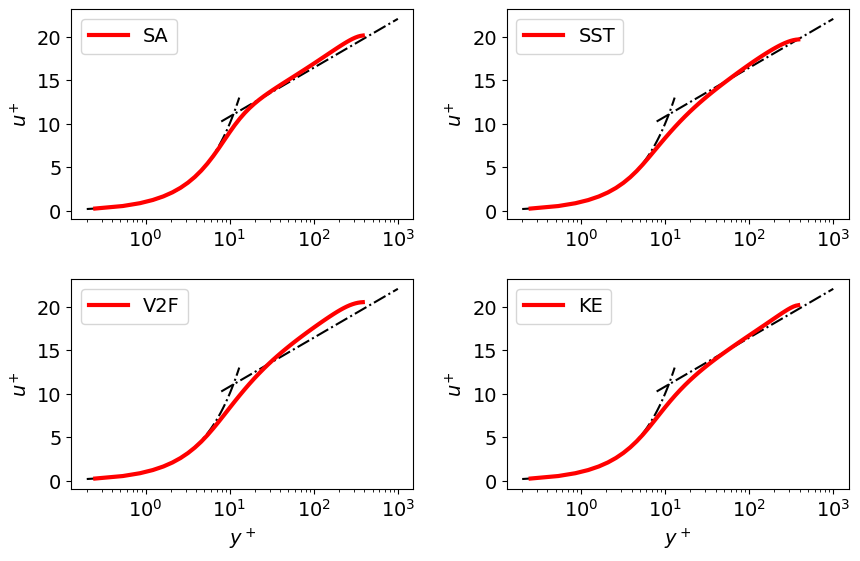

In [20]:
ypl1 = mesh.y*ReTau

# analytic results for viscous sub-layer
ypLam = np.linspace(0.2,13,100); 
    
# semi-empirical result for log-layer
ypTurb = np.linspace(0.9,3,20)
upTurb = 1/0.41*np.log(np.power(10, ypTurb))+5.2

fig, axs = plt.subplots(2, 2,figsize=(9,6),dpi=100)

axs[0, 0].semilogx(ypLam,ypLam,'k-.')
axs[0, 0].semilogx(np.power(10, ypTurb), upTurb,'k-.')
axs[0, 0].semilogx(ypl1[1:n//2],u1[1:n//2],'r-',linewidth=3,label='SA')
axs[0, 0].set_ylabel('$u^{+}$', fontsize=14)
axs[0, 0].legend()

axs[0, 1].semilogx(ypLam,ypLam,'k-.')
axs[0, 1].semilogx(np.power(10, ypTurb), upTurb,'k-.')
axs[0, 1].semilogx(ypl1[1:n//2],u2[1:n//2],'r-',linewidth=3,label='SST')
axs[0, 1].set_ylabel('$u^{+}$', fontsize=14)
axs[0, 1].legend()

axs[1, 0].semilogx(ypLam,ypLam,'k-.')
axs[1, 0].semilogx(np.power(10, ypTurb), upTurb,'k-.')
axs[1, 0].semilogx(ypl1[1:n//2],u3[1:n//2],'r-',linewidth=3,label='V2F')
axs[1, 0].set_xlabel('$y^+$', fontsize=14)
axs[1, 0].set_ylabel('$u^{+}$', fontsize=14)
axs[1, 0].legend()

axs[1, 1].semilogx(ypLam,ypLam,'k-.')
axs[1, 1].semilogx(np.power(10, ypTurb), upTurb,'k-.')
axs[1, 1].semilogx(ypl1[1:n//2],u4[1:n//2],'r-',linewidth=3,label='KE')
axs[1, 1].set_xlabel('$y^+$', fontsize=14)
axs[1, 1].set_ylabel('$u^{+}$', fontsize=14)
axs[1, 1].legend()
fig.tight_layout(pad=1.5)